# 基于“货币-信用”状态的BL资产配置模型

用模拟组合，在无卖空条件下，分别实现马科维茨模型的配置结果，和包含“货币-信用”观点的Black-Litterman模型配置结果。
## 设定组合资产
价值股:国证价值指数  399371.SZ
成长股:国证成长指数  399370.SZ
无风险资产：10Y国债收益率
## 均值方差模型下的市场最大化夏普配置结果
## 市场均衡收益率下的BL模型配置结果


In [1]:
### 数据库导入
from iFinDPy import *
from datetime import datetime
import pandas as pd
import time as _time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


e:\Program Files\Python310\Lib\site-packages\iFinDPy.pth


In [2]:
### 同花顺登陆
user_name,password = ["hacb201","976306"]
def thslogindemo(us,psw):
    # 输入用户的帐号和密码
    thsLogin = THS_iFinDLogin(us,psw)
    print(thsLogin)
    if thsLogin != 0:
        print('登录失败')
    else:
        print('登录成功')

thslogindemo(user_name,password)

0
登录成功


In [3]:
### 抓取数据及数据清洗
#申万一级行业、31个行业
index_list = ['801010.SL,801030.SL,801040.SL,801050.SL,801080.SL,801110.SL,801120.SL,801130.SL,801140.SL,801150.SL,801160.SL,801170.SL,801180.SL,801200.SL,801210.SL,801230.SL,801710.SL,801720.SL,801730.SL,801740.SL,801750.SL,801760.SL,801770.SL,801780.SL,801790.SL,801880.SL,801890.SL,801950.SL,801960.SL,801970.SL,801980.SL']
#指数简称
data_js_name = THS_BD(index_list,'ths_index_short_name_index','')
data_df_name = data_js_name.data
data_df_name.rename(columns={'ths_index_short_name_index':'证券简称'}, inplace=True) # type: ignore
print('数据示例为{}，空行数为{}'.format(data_df_name.head(1),sum(data_df_name.thscode.isna()))) # type: ignore)
#总市值、流通市值
data_js_mcap = THS_BD(index_list,'ths_market_value_hb_index;ths_current_mv_hb_index;ths_ashare_mv_hb_index','2023-03-16;2023-03-16;2023-03-16')
data_df_mcap = data_js_mcap.data
data_df_mcap.rename(columns={'ths_market_value_hb_index':'总市值', 'ths_current_mv_hb_index':'A股市值', 'ths_ashare_mv_hb_index':'流通市值'}, inplace=True)
print('数据示例为{}，空行数为{}'.format(data_df_mcap.head(1),sum(data_df_mcap.thscode.isna())))
#日涨跌幅
#日期序列-指数-收盘价;涨跌幅-iFinD数据接口
data_js = THS_DS(index_list,'ths_close_price_index;ths_chg_ratio_index',';','block:history','2022-10-01','2023-03-16')
data_df = data_js.data
print('数据示例为{}，空行数为{}'.format(data_df.head(1),sum(data_df.thscode.isna())))

数据示例为     thscode  证券简称
0  801010.SL  农林牧渔，空行数为0
数据示例为     thscode           总市值          A股市值          流通市值
0  801010.SL  1.510176e+12  1.077746e+12  1.507535e+12，空行数为0
数据示例为         time    thscode  ths_close_price_index  ths_chg_ratio_index
0  2022-10-10  801010.SL                3399.91             3.350782，空行数为0


In [4]:
data_df_mcap.head(2)

,thscode,总市值,A股市值,流通市值
0,801010.SL,1.510176e+12,1.077746e+12,1.507535e+12
1,801030.SL,3.568469e+12,3.010375e+12,3.555081e+12


In [5]:
# 数据处理
data_df2 = data_df.merge(data_df_name,on='thscode',how='left')
print(data_df2.证券简称.isna().sum())
data_df_mcap2 = data_df_mcap.merge(data_df_name,on='thscode',how='left')
print(data_df_mcap2.证券简称.isna().sum())
'''
join()方法是基于索引（index）来拼接的，而merge()方法可以指定任意的列或索引作为拼接的依据。
join()方法默认使用左连接（left join），而merge()方法默认使用内连接（inner join）
merge()方法会创建一个新的索引，而join()方法会保留左边dataframe的索引。这可能会影响后续的数据处理。
'''

0
0


'\njoin()方法是基于索引（index）来拼接的，而merge()方法可以指定任意的列或索引作为拼接的依据。\njoin()方法默认使用左连接（left join），而merge()方法默认使用内连接（inner join）\nmerge()方法会创建一个新的索引，而join()方法会保留左边dataframe的索引。这可能会影响后续的数据处理。\n'

In [6]:
### 定义无风险收益率和tau
Goverment_bond_YTM_10Y = 0.0283 
tau = 0.025

In [7]:
### 计算历史协方差矩阵、收益率均值向量
data_df_pivot = data_df2.pivot(index='time',columns='证券简称', values='ths_chg_ratio_index')
#print(data_df_pivot.tail(2))
Pi = data_df_pivot.mean()*252
sigma = data_df_pivot.cov()*252
print(Pi,sigma)

证券简称
交通运输    13.425193
传媒      61.420448
公用事业     6.913978
农林牧渔     2.423445
医药生物    31.817003
商贸零售     5.022466
国防军工    15.724599
基础化工     7.443508
家用电器    11.082886
建筑材料    20.454832
建筑装饰    44.255809
房地产     -8.136365
有色金属     4.916442
机械设备    33.092486
汽车       0.600823
煤炭     -37.490440
环保      19.811248
电力设备   -14.674633
电子      25.373859
石油石化     4.872749
社会服务    41.661942
纺织服饰    27.682931
综合      19.034183
美容护理    17.259315
计算机     80.728245
轻工制造    28.030101
通信      54.862372
钢铁      26.642434
银行       6.351796
非银金融    24.477222
食品饮料     8.181503
dtype: float64 证券简称        交通运输          传媒        公用事业        农林牧渔        医药生物        商贸零售  \
证券简称                                                                           
交通运输  338.960371  248.388516  130.365739  182.913909  187.980455  300.063884   
传媒    248.388516  581.341729  123.899776  203.551659  267.808415  334.730928   
公用事业  130.365739  123.899776  223.135295  115.054455   92.618088  112.897564   
农林牧渔  182.913909  203.

[2.41842361e-16 1.90704271e-02 7.65915420e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.20214618e-16 0.00000000e+00
 0.00000000e+00 1.20998000e-15 3.52549523e-01 1.39783597e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.29005370e-16
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.01576318e-16
 1.11068524e-01 3.99319139e-17 0.00000000e+00 0.00000000e+00
 5.17311525e-01 1.81692116e-17 0.00000000e+00 5.63959033e-16
 3.56699876e-16 5.23097633e-16 0.00000000e+00] 63.16266024056269 19.843482478748186


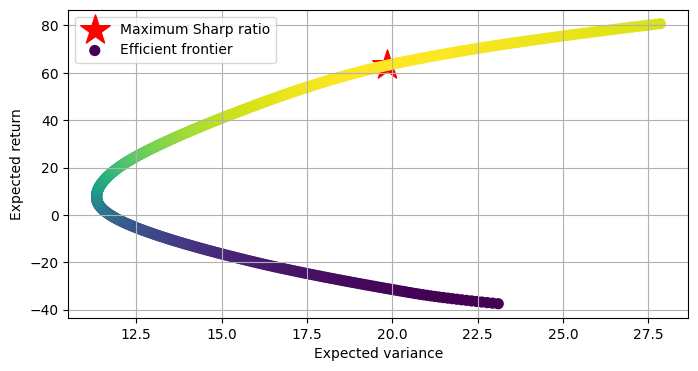

In [8]:
### 计算均值-方差模型得到最大夏普的市场权重
'''
scipy.optimize.minimize函数的返回值，是一个OptimizeResult对象，包含了最优化过程的信息。最优化结果result有以下属性：

x: 最优解
success: 布尔值，表示是否成功找到最优解
status: 整数，表示最优化过程的状态码
message: 字符串，表示最优化过程的终止原因
fun: 浮点数，表示目标函数在最优解处的值
jac: 数组，表示目标函数在最优解处的梯度
hess: 矩阵或者线性算子，表示目标函数在最优解处的海森矩阵或者近似
nfev: 整数，表示目标函数被调用的次数
njev: 整数，表示梯度被调用的次数
nhev: 整数，表示海森矩阵被调用的次数
nit: 整数，表示迭代次数
'''
# 定义组合收益率和方差计算
def port_return(weights, returns):
    return np.sum(weights * returns.mean(axis = 0)*252) #单利年化

def port_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252, weights)))

# 定义目标函数
def sharp_ratio(weights, returns, risk_free_date):
    portfolio_return = np.sum(weights * returns.mean(axis = 0)*252)
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252, weights)))
    sharp_ratio = (portfolio_return - risk_free_date) / portfolio_volatility
    return -sharp_ratio
# 定义最优化函数（拉格朗日乘子法），计算最大夏普
initial_weitghts = np.ones(len(data_df_pivot.columns),)/len(data_df_pivot.columns)
bounds = [(0,1)] * len(data_df_pivot.columns)
constraints = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'ineq','fun':lambda x:x} #ineq表示不等式约束，表示大于等0，对应禁止卖空
)
# 求解权重
result = minimize(sharp_ratio, initial_weitghts,args=(data_df_pivot,Goverment_bond_YTM_10Y), method='SLSQP',bounds=bounds, constraints=constraints)
print(result.x, port_return(result.x, data_df_pivot), port_volatility(result.x, data_df_pivot))
# 绘制有效前沿曲线
plt.figure(figsize=(8,4))
plt.scatter(port_volatility(result.x, data_df_pivot),port_return(result.x, data_df_pivot), marker='*', color='r', s=500,
            label='Maximum Sharp ratio')

target_returns1 = np.linspace(min(Pi), max(Pi), 500)
target_volatility1 = []
# 有效前沿曲线 波动率与期望收益的市场组合曲线
for tar in target_returns1:
    constraints_for = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'eq','fun': lambda x: port_return(x, data_df_pivot)-tar} #约束组合收益率等于tar。这样就可以得到在不同目标收益率下的最小方差
    )
    result_for = minimize(port_volatility,initial_weitghts,method='SLSQP',
                          bounds=bounds,
                          args=(data_df_pivot),
                          constraints=constraints_for)
#    print(tar-port_return(result_for.x, data_df_pivot))
    target_volatility1.append(result_for.fun)
target_volatility1 = np.array(target_volatility1)
plt.scatter(target_volatility1,target_returns1,c=(target_returns1-Goverment_bond_YTM_10Y)/target_volatility1, s=50,
            label = 'Efficient frontier') # c: 散点的颜色，可以是一个标量或者一个数组，这里是target_returns/target_vars，表示每个散点的颜色由其夏普比率决定
plt.grid(True)
plt.xlabel('Expected variance')
plt.ylabel('Expected return')
plt.legend(loc='best')
plt.show()

In [9]:
for i in range(len(result.x)):
    print('{}行业的配置比例为{:.2f}%，今年以来的收益率均值(年化)为{:.2f}'.format(data_df_pivot.columns[i], result.x[i]*100, Pi[i]))

交通运输行业的配置比例为0.00%，今年以来的收益率均值(年化)为13.43
传媒行业的配置比例为1.91%，今年以来的收益率均值(年化)为61.42
公用事业行业的配置比例为0.00%，今年以来的收益率均值(年化)为6.91
农林牧渔行业的配置比例为0.00%，今年以来的收益率均值(年化)为2.42
医药生物行业的配置比例为0.00%，今年以来的收益率均值(年化)为31.82
商贸零售行业的配置比例为0.00%，今年以来的收益率均值(年化)为5.02
国防军工行业的配置比例为0.00%，今年以来的收益率均值(年化)为15.72
基础化工行业的配置比例为0.00%，今年以来的收益率均值(年化)为7.44
家用电器行业的配置比例为0.00%，今年以来的收益率均值(年化)为11.08
建筑材料行业的配置比例为0.00%，今年以来的收益率均值(年化)为20.45
建筑装饰行业的配置比例为35.25%，今年以来的收益率均值(年化)为44.26
房地产行业的配置比例为0.00%，今年以来的收益率均值(年化)为-8.14
有色金属行业的配置比例为0.00%，今年以来的收益率均值(年化)为4.92
机械设备行业的配置比例为0.00%，今年以来的收益率均值(年化)为33.09
汽车行业的配置比例为0.00%，今年以来的收益率均值(年化)为0.60
煤炭行业的配置比例为0.00%，今年以来的收益率均值(年化)为-37.49
环保行业的配置比例为0.00%，今年以来的收益率均值(年化)为19.81
电力设备行业的配置比例为0.00%，今年以来的收益率均值(年化)为-14.67
电子行业的配置比例为0.00%，今年以来的收益率均值(年化)为25.37
石油石化行业的配置比例为0.00%，今年以来的收益率均值(年化)为4.87
社会服务行业的配置比例为11.11%，今年以来的收益率均值(年化)为41.66
纺织服饰行业的配置比例为0.00%，今年以来的收益率均值(年化)为27.68
综合行业的配置比例为0.00%，今年以来的收益率均值(年化)为19.03
美容护理行业的配置比例为0.00%，今年以来的收益率均值(年化)为17.26
计算机行业的配置比例为51.73%，今年以来的收益率均值(年化)为80.73
轻工制造行业的配置比例为0.00%，今年以来的收益率均值(年化)为28.03
通信

In [10]:
### 计算先验分布：市场均衡权重、均衡收益率、风险厌恶系数
#市值占比权重
data_df_mcap2['市值占比'] = data_df_mcap2['总市值'].apply(lambda x: x / data_df_mcap2['总市值'].sum()).round(4)
weights_mrk = np.array(data_df_mcap2['市值占比'])
#迭代计算均衡超额收益率和风险厌恶系数
def port_prior_return_lambd(weights, returns, risk_free_date):
    lambd =(port_return(weights=weights,returns=returns)-risk_free_date)/(port_volatility(weights=weights, returns=returns)**2)
    prior_return = lambd * np.dot(returns.cov()*252, weights)
    return lambd, prior_return

lambd, prior_return= port_prior_return_lambd(weights_mrk, data_df_pivot, Goverment_bond_YTM_10Y)

In [11]:
data_df_name

,thscode,证券简称
0,801010.SL,农林牧渔
1,801030.SL,基础化工
2,801040.SL,钢铁
3,801050.SL,有色金属
4,801080.SL,电子
5,801110.SL,家用电器
6,801120.SL,食品饮料
7,801130.SL,纺织服饰
8,801140.SL,轻工制造
9,801150.SL,医药生物


In [242]:
### 设定市场观点。计算观点矩阵、观点收益率向量、观点协方差矩阵
'''
观点1：食品饮料行业收益率比汽车行业高5%
观点2：非银金融行业收益率比银行高3%
观点3：房地产行业的预期收益率室-10%
'''
data_df_name[['观点1','观点2','观点3']] = 0 # type: ignore
data_df_name.loc[(data_df_name['证券简称'] == '食品饮料'),'观点1'] = 1
data_df_name.loc[(data_df_name['证券简称'] == '汽车'),'观点1'] = -1
data_df_name.loc[(data_df_name['证券简称'] == '非银金融'),'观点2'] = 1
data_df_name.loc[(data_df_name['证券简称'] == '银行'),'观点2'] = -1
data_df_name.loc[(data_df_name['证券简称'] == '房地产'),'观点3'] = 1
#设定观点矩阵P和观点收益率向量Q
P = np.array(data_df_name[['观点1','观点2','观点3']].T.reset_index(drop=True))
Q = np.array([0.05, 0.03, -0.10])
tau_of_Q = np.diag([0.2, 0.6, 0.8])
#计算 Ω 观点协方差矩阵
def port_omega_cov(views,tau,sigma):
    dig = np.diag(np.dot(P,(np.dot(sigma,P.T))))
    omega_cov = np.diag(dig)
    return omega_cov
omega_cov = port_omega_cov(P, tau, sigma)

In [247]:
np.diag(np.diag(np.dot(P,(np.dot(sigma,P.T)))))

array([[ 599.38070134,    0.        ,    0.        ],
       [   0.        , 1052.68254539,    0.        ],
       [   0.        ,    0.        ,  547.73504581]])

In [251]:
np.diag([0.2*tau, 0.6*tau, 0.8*tau])*np.diag(np.diag(np.dot(P,(np.dot(sigma,P.T)))))

array([[ 2.99690351,  0.        ,  0.        ],
       [ 0.        , 15.79023818,  0.        ],
       [ 0.        ,  0.        , 10.95470092]])

使用[]运算符来对dataframe进行切片，选择一部分行和/或列。
data[start:stop] 选择从start到stop（不包括stop）的行。
data[column] 选择名为column的列。
data[[column1, column2]] 选择名为column1和column2的列。
data.loc[row_label, column_label] 选择指定行标签和列标签的单元格。
data.iloc[row_index, column_index] 选择指定行索引和列索引的单元格。

In [ ]:
### 计算后验分布收益率及方差
def port_post_retrun():
    k = np.linalg.inv(np.linalg.inv(tau * sigma) +np.dot(np.dot(P.T, np.linalg.inv(omega_cov)), P))


((sigma*tau)^-1 +(P.T Ω^-1 P))^-1

In [ ]:
### 计算后验分布的资产权重